In [0]:
!nvidia-smi

Mon Aug  5 05:17:26 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DRIVE_URL=f"/content/drive/My Drive/gsoc_images"

In [0]:
%cd {DRIVE_URL}
!cp images.zip /content/images.zip
!cp rkd_cnn_train.csv /content/rkd_cnn_train.csv
%cd /content/

/content/drive/My Drive/gsoc_images
/content


In [0]:
!unzip -q images.zip

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [0]:
np.random.seed(2)

In [0]:
import re
def preprocess_df(df, offset):
    def extract(s):
        arr = p.split(s)
        q = s[:2]
        l = 0
        for idx,k in enumerate([arr[2],arr[4], arr[6]]):
            if k is not None:
                if idx == 0:
                    if len(k) >= 2 and k[0] == k[1]:
                        k = k[0]+k[2:]
                    x = k[:offset]
                    q += x
                    l += len(x)
                elif l + 1 <= offset:
                    q += k
                    l += 1
                elif l + 2 <= offset:
                    q += k
                    l += 1
        return q
    
    p = re.compile(r"(\d{1,2})([A-Z]{1,2}\d{0,})?(\(...\))?(\(([A-Z\ ]+)\))?(\((\+\d+)\))?")
    df['IC1'] = pd.Series(
        map(lambda x: ",".join(set(map(lambda y: extract(y.strip()), x))),
            df['Iconclass'].str.split(",")))
    df['IMG'] = df["Id"].astype(str).__add__(".jpg")
    return df

In [0]:
df = preprocess_df(pd.read_csv("rkd_cnn_train.csv"), offset=2)
#df = pd.read_csv("rkd_cnn_train.csv")

In [0]:
PATH = f"./images"

In [0]:
df[:20]

,Id,Iconclass,Valid,IC1,IMG
0,5463,"73B81(+3),73B8",False,73B8,5463.jpg
1,37696,"73D721,73D723,73D81",False,"73D8,73D7",37696.jpg
2,216270,73D641(+5),False,73D6,216270.jpg
3,255017,73D231,True,73D2,255017.jpg
4,52981,73D722,False,73D7,52981.jpg
5,43348,73D41,False,73D4,43348.jpg
6,54943,73B57,False,73B5,54943.jpg
7,21060,73DD61,False,73D6,21060.jpg
8,53252,73D15,False,73D1,53252.jpg
9,266022,73E5,True,73E5,266022.jpg


In [0]:
src = ImageList.from_df(df[['IMG','IC1','Valid']],PATH).split_from_df().label_from_df(label_delim=',')

In [0]:
data = src.transform(get_transforms(max_rotate=2.0,max_warp=0.0), size=128).databunch(bs=256).normalize(imagenet_stats)

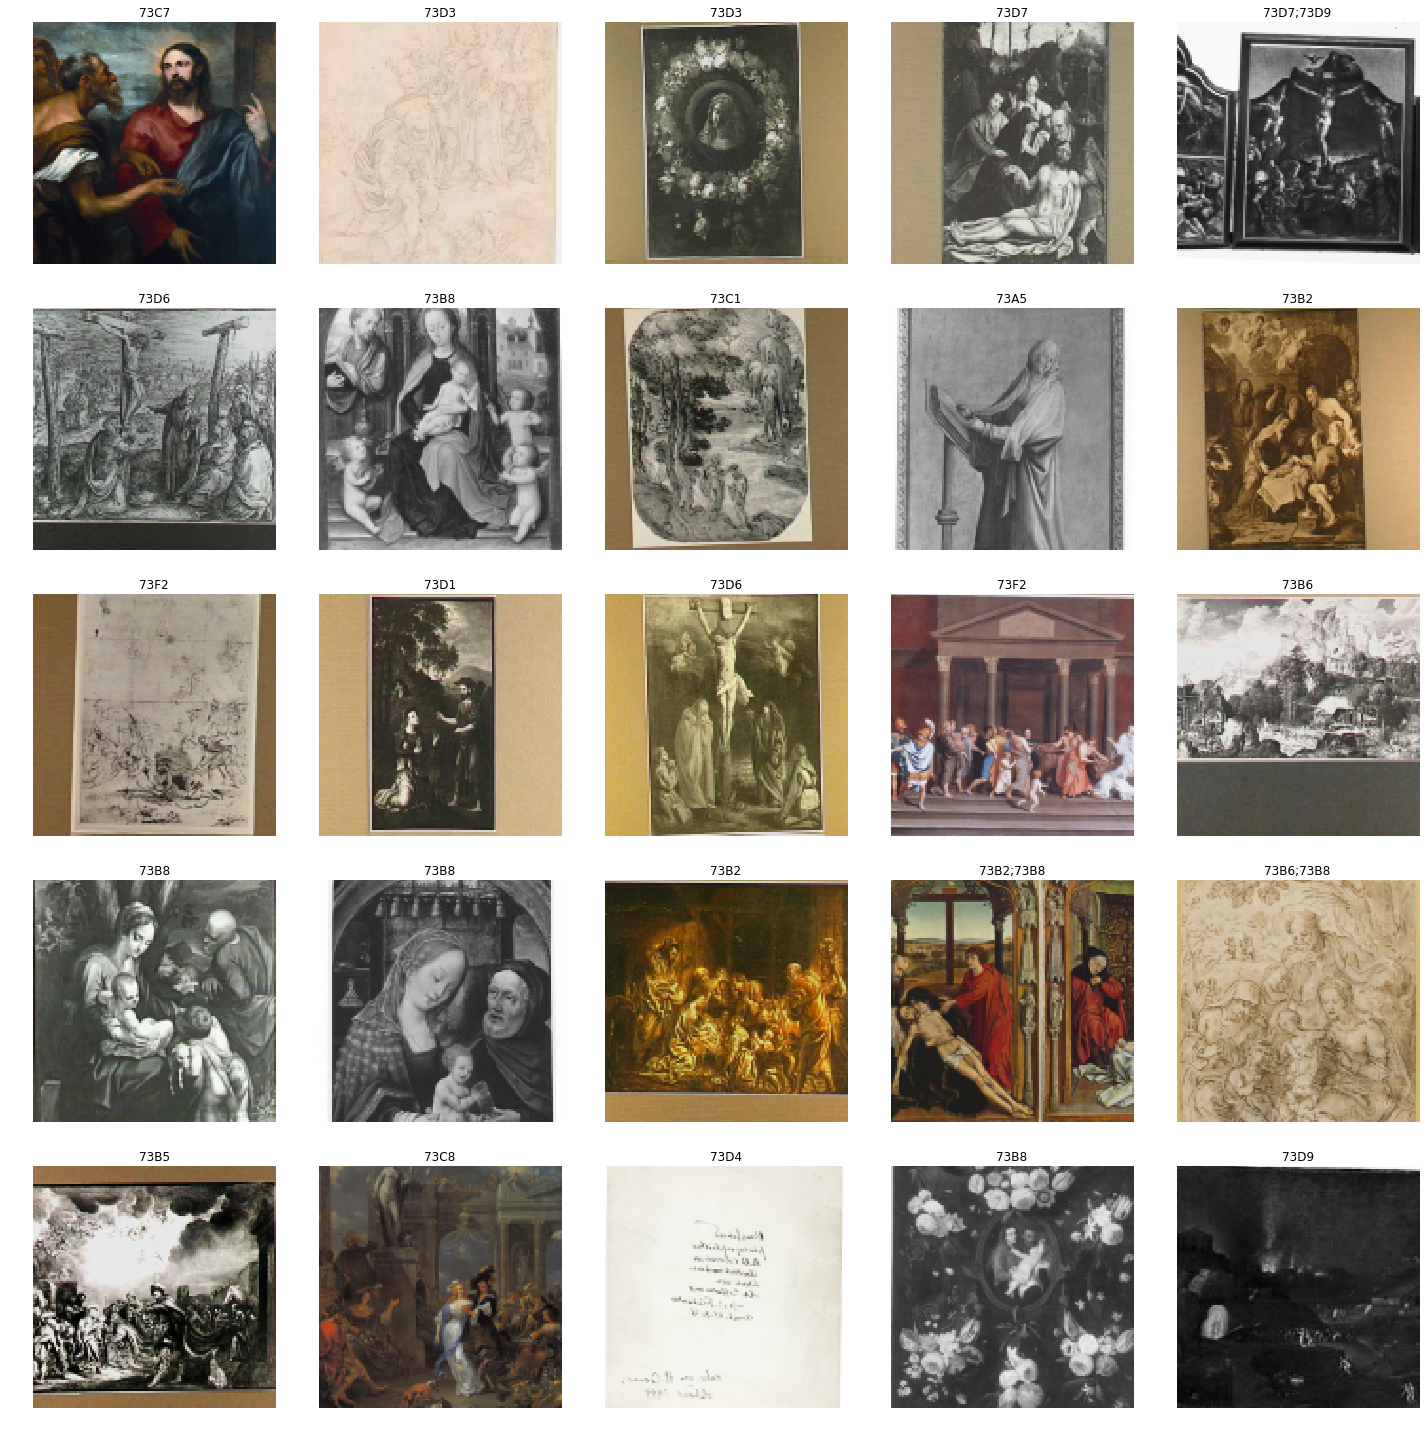

In [0]:
data.show_batch()

In [0]:
arch = models.resnet50

In [0]:
th = 0.2
acc_02 = partial(accuracy_thresh, thresh=th)
#f_score = partial(fbeta, thresh=th)
mlfb = partial(MultiLabelFbeta,thresh=th, average='micro', beta=2)

In [0]:
%cd {DRIVE_URL}
learn= load_learner('images','stage-1-best.pkl')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
learn.model[1] = create_head(num_features_model(nn.Sequential(*learn.model[0].children())) * 2,data.c).to(data.device)

In [0]:
apply_init(learn.model[1],nn.init.kaiming_normal_)

In [0]:
learn = learn.split(lambda m: (m[0][6],m[1]))

In [0]:
learn.data = data

In [0]:
learn.freeze()

In [0]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


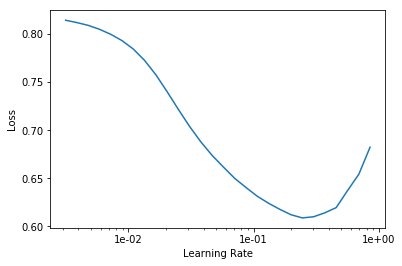

In [0]:
learn.recorder.plot(skip_start=50,skip_end=5)

In [0]:
learn.fit_one_cycle(20,slice(3e-2))

epoch,train_loss,valid_loss,accuracy_thresh,micro_fbeta,time
0,0.682291,0.455171,0.056592,0.102001,01:55
1,0.345471,0.119528,0.975041,0.168963,01:55
2,0.196179,0.100397,0.965659,0.408105,01:55
3,0.125891,0.093464,0.969029,0.457645,01:55
4,0.090006,0.093078,0.972074,0.478721,01:54
5,0.070619,0.096383,0.971021,0.482785,01:55
6,0.059721,0.095508,0.969474,0.488951,01:55
7,0.052983,0.093696,0.968054,0.504372,01:56
8,0.048585,0.094555,0.971948,0.516411,01:55
9,0.045690,0.098055,0.969209,0.523528,01:55


In [0]:
%cd {DRIVE_URL}
learn.save('RKD2_frozen_e20_f06268b256')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
%cd {DRIVE_URL}
learn.load('RKD2_frozen_e20_f06268b256')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


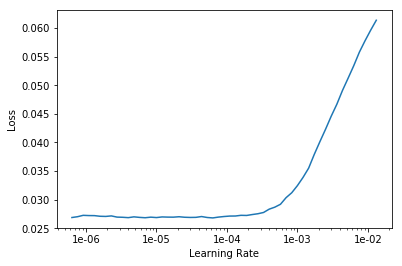

In [0]:
learn.recorder.plot(skip_end=20)

In [0]:
learn.fit_one_cycle(20,slice(1e-5,2e-3))

epoch,train_loss,valid_loss,accuracy_thresh,micro_fbeta,time
0,0.027431,0.104567,0.972502,0.623352,02:35
1,0.027277,0.105226,0.972062,0.623936,02:36
2,0.027089,0.109400,0.971412,0.626948,02:36
3,0.027193,0.109713,0.971412,0.627110,02:36
4,0.027800,0.114342,0.970690,0.614328,02:36
5,0.028273,0.113248,0.969787,0.615968,02:38
6,0.027851,0.110426,0.971292,0.627072,02:38
7,0.026465,0.110605,0.971376,0.645128,02:36
8,0.024609,0.113372,0.971563,0.655883,02:37
9,0.022680,0.114544,0.972195,0.669995,02:38


In [0]:
%cd {DRIVE_URL}
learn.save('RKD2_unfrozen_e20_f07364b256')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
%cd {DRIVE_URL}
learn.load('RKD2_unfrozen_e20_f07364b256')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
learn.validate()

[0.11552377, tensor(0.9745)]

In [0]:
%cd {DRIVE_URL}
learn.export('stage-2-best.pkl')
%cd /content

/content/drive/My Drive/gsoc_images
/content
